<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/AnaCRV_INP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install kerberos

In [ ]:
!apt-get install krb5-user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  bind9-host geoip-database krb5-config libbind9-160 libdns1100 libgeoip1
  libgssrpc4 libisc169 libisccc160 libisccfg160 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9 liblwres160
Suggested packages:
  geoip-bin krb5-doc
The following NEW packages will be installed:
  bind9-host geoip-database krb5-config krb5-user libbind9-160 libdns1100
  libgeoip1 libgssrpc4 libisc169 libisccc160 libisccfg160 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9 liblwres160
0 upgraded, 15 newly installed, 0 to remove and 39 not upgraded.
Need to get 3,848 kB of archives.
After this operation, 15.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libisc169 amd64 1:9.11.3+dfsg-1ubuntu1.15 [238 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgeoip1 amd64 1.6.12-1 [71.8 kB]
Get:3 http:/

In [ ]:
!wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf

--2021-06-18 17:33:00--  https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
Resolving authentication.fnal.gov (authentication.fnal.gov)... 131.225.105.240, 2620:6a:0:105::105:240
Connecting to authentication.fnal.gov (authentication.fnal.gov)|131.225.105.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486 (17K) [text/plain]
Saving to: ‘krb5.conf’

krb5.conf           100%[===================>]  17.08K  --.-KB/s    in 0.05s   

2021-06-18 17:33:00 (347 KB/s) - ‘krb5.conf’ saved [17486/17486]



In [ ]:
import os
os.environ['KRB5_CONFIG'] = 'krb5.conf'

#Copy files from FNAL

In [ ]:
!kinit oksuzian@FNAL.GOV

Password for oksuzian@FNAL.GOV: 


In [ ]:
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.owner.trkana-reco.version.sequencer.cry4v940loreco17000_v1.root .

In [ ]:
!cp nts.*.root drive/MyDrive/root_files_oksuzian/

#Init

In [ ]:
import sys

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/'
except:
    main_path = ''
sys.path.append(main_path)

Mounted at /content/drive


In [ ]:
%pip install uproot3

     |████████████████████████████████| 122kB 5.2MB/s 
     |████████████████████████████████| 92kB 5.2MB/s 


In [ ]:
def default_flatname(branchname, fieldname, index):
    """This replaces the dot in the column names with underscores"""
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

In [ ]:
import uproot3
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from plotly import graph_objs as go
import pylab
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

#Keras libs
import keras
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Activation
from keras.layers import BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.optimizers import Adam
import keras.backend as k

import math
import sklearn.utils
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import brier_score_loss
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, plot_confusion_matrix

#Load dataframes

In [ ]:
fileH = uproot3.open("drive/MyDrive/root_files_oksuzian/nts.owner.trkana-reco.version.sequencer.cry4v940loreco17000_v1.root")
fileL = uproot3.open("drive/MyDrive/root_files_oksuzian/nts.owner.trkana-reco.version.sequencer.cry4v940loreco17000_v1.root")
trkanaH = fileH["TrkAnaNeg"]["trkana"]
trkanaL = fileL["TrkAnaNeg"]["trkana"]


In [ ]:
dfL_eve = trkanaL.pandas.df(['*'], flatname=default_flatname, flatten=False)

In [ ]:
dfL_eve = trkanaL.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*', '_*'], flatname=default_flatname, flatten=True)
dfL_crv = trkanaL.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfH_eve = trkanaH.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*', '_*'], flatname=default_flatname, flatten=True)
dfH_crv = trkanaH.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfL_crv = dfL_crv[dfL_crv.index.get_level_values('subentry') == dfL_crv["bestcrv"]]
dfH_crv = dfH_crv[dfH_crv.index.get_level_values('subentry') == dfH_crv["bestcrv"]]

pd.merge(dfL_eve, dfL_crv, how="left", on='entry')
dfL = dfL_eve.merge(dfL_crv, how="left", on="entry")
dfH = dfH_eve.merge(dfH_crv, how="left", on="entry")

dfH['is_high'] = 1
dfL['is_high'] = 0

df = pd.concat([dfH, dfL], axis=0)
df["crvinfo__dT"] = df["crvinfo__timeWindowStart"] - df["de_t0"]
df['deent_d0_om'] = df["deent_d0"]+2.0/df["deent_om"]
df["is_triggered"] = (df["trigbits"].values & 0x208) > 0

df = df.fillna(-999999)

In [ ]:
#df.to_hdf('drive/MyDrive/root_files/cosmic_ce_cominded.h5', key='df', mode='w')
#pd.read_hdf('drive/MyDrive/root_files/cosmic_ce_cominded.h5', 'df')

#Define cuts

In [ ]:
#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "((deent_d0 + 2./deent_om) > 450)",
    "((deent_d0 + 2./deent_om) < 680)",
    "(is_triggered)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(deent_mom > 100)",
    "(deent_mom < 110)"
]
cut_extmom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "((deent_d0 + 2./deent_om) > 450)",
    "(is_triggered)"
]
cut_lbox = " & ".join(cuts)

crv_time = "((-de_t0 + crvinfo__timeWindowStart) > 50 | (de_t0-crvinfo__timeWindowStart) > 150.0)"



In [ ]:
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

In [ ]:
df_cut_nomom = df.query(cut_nomom)
df_cut_extmom = df.query(cut_extmom)
df_cut_loose = df.query(cut_loose)
df_time = df.query(crv_time + " & " + cut_nomom)

df = df.query(cut_pid_trkqual_ue)

#Make plots

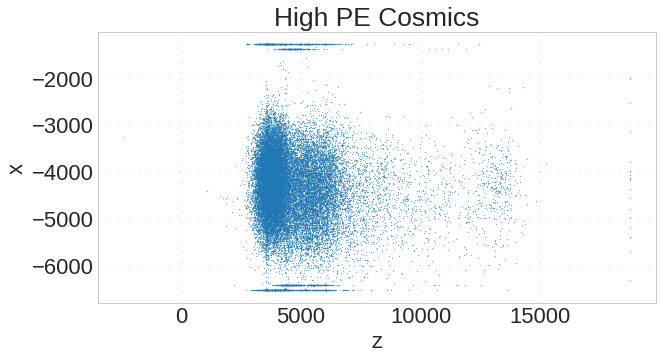

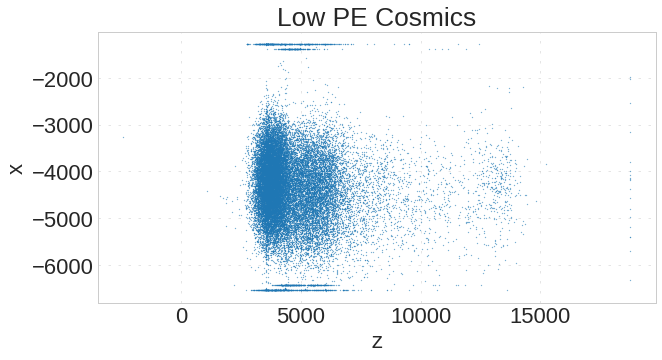

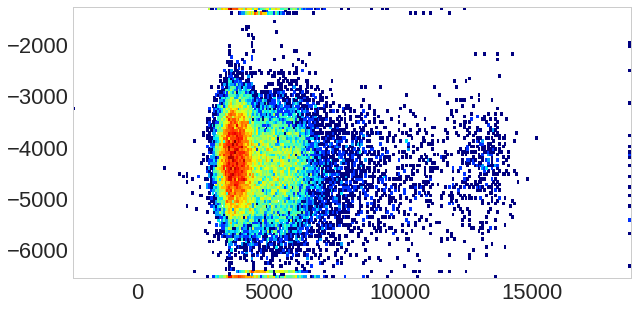

In [ ]:
import matplotlib as mpl

plt.plot(df.query('is_high == 1 & crvinfo__timeWindowStart>0')['crvinfomc__z'], df.query('is_high == 1 & crvinfo__timeWindowStart>0')['crvinfomc__x'], '.', markersize=0.5);
plt.title("High PE Cosmics");
plt.xlabel("z");
plt.ylabel("x");
plt.figure()
plt.plot(df.query('is_high == 0 & crvinfo__timeWindowStart>0')['crvinfomc__z'], df.query('is_high == 0 & crvinfo__timeWindowStart>0')['crvinfomc__x'], '.', markersize=0.5);
plt.title("Low PE Cosmics");
plt.xlabel("z");
plt.ylabel("x");
plt.figure()
plt.hist2d(df.query('is_high == 0 & crvinfo__timeWindowStart>0')['crvinfomc__z'], df.query('is_high == 0 & crvinfo__timeWindowStart>0')['crvinfomc__x'], bins=(300, 100), norm=mpl.colors.LogNorm(), cmap = plt.cm.jet);


In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

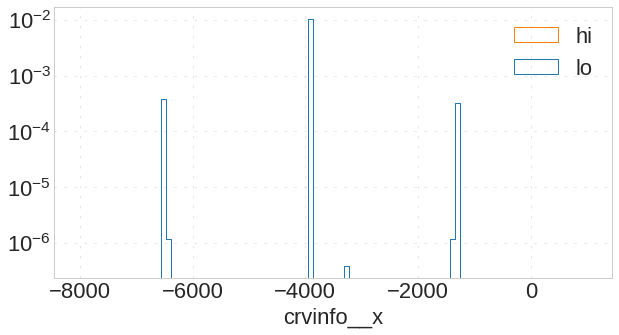

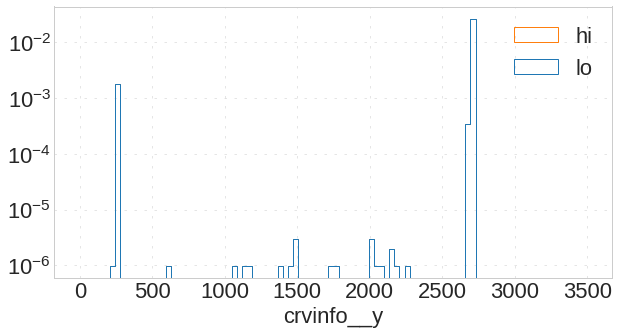

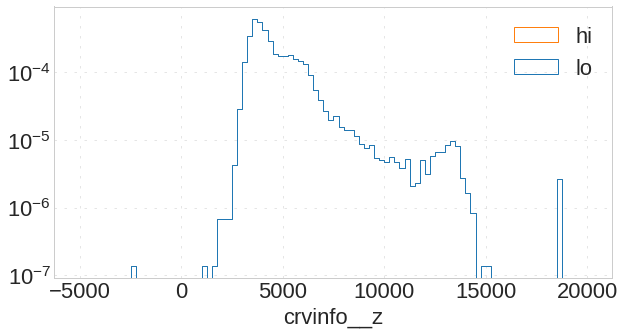

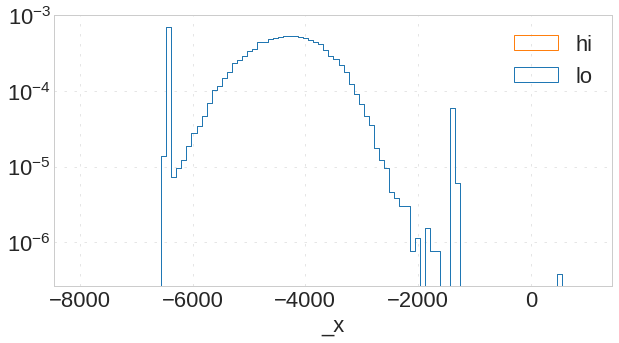

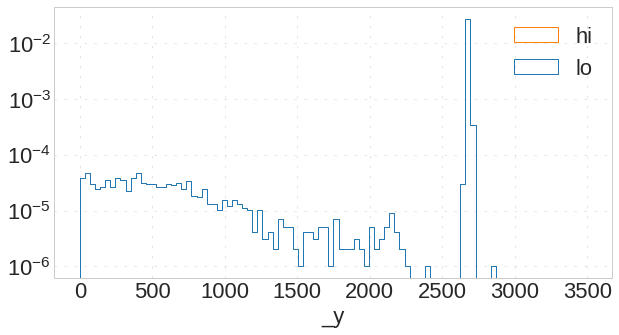

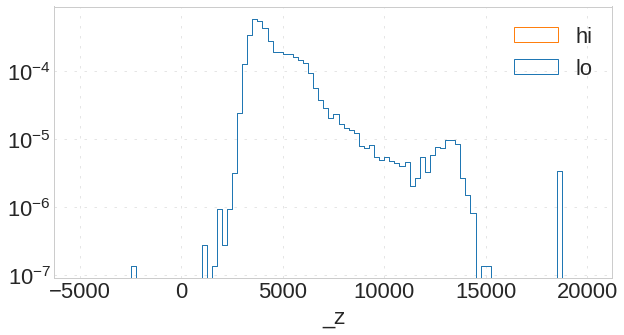

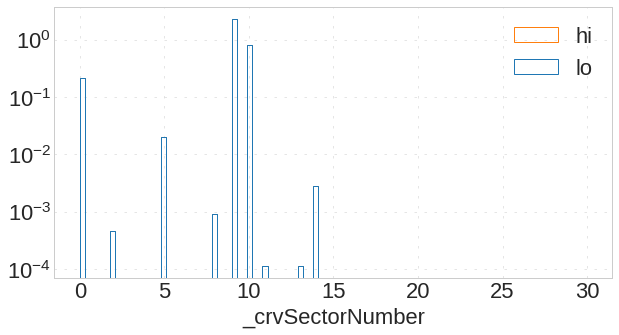

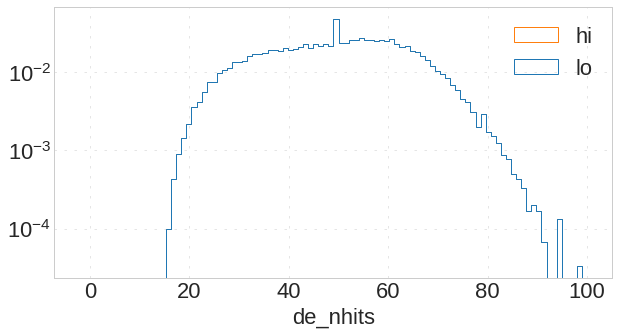

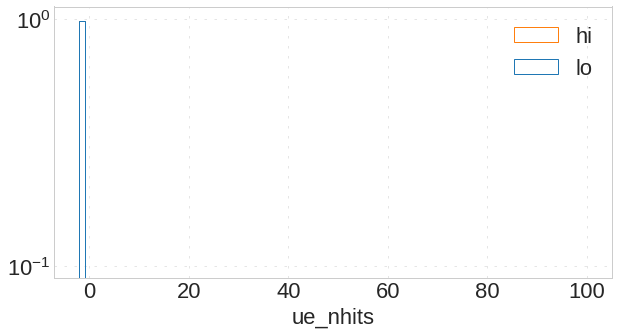

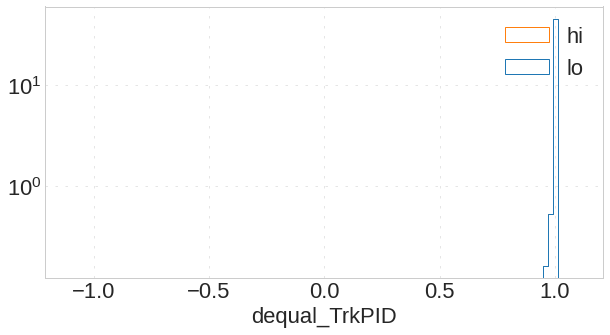

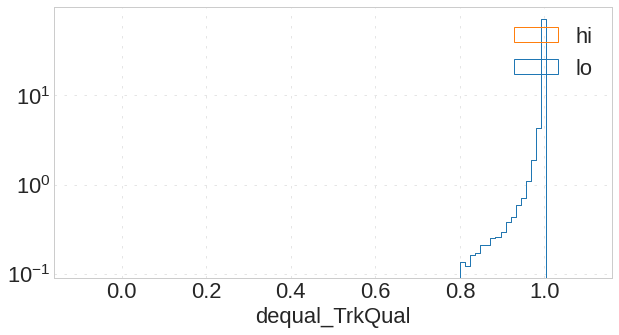

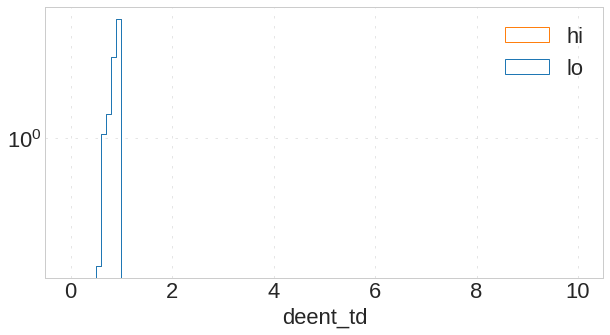

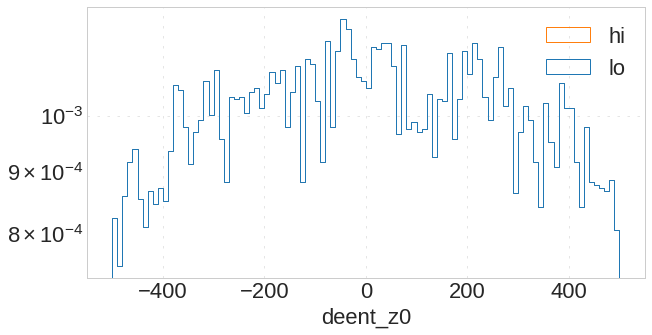

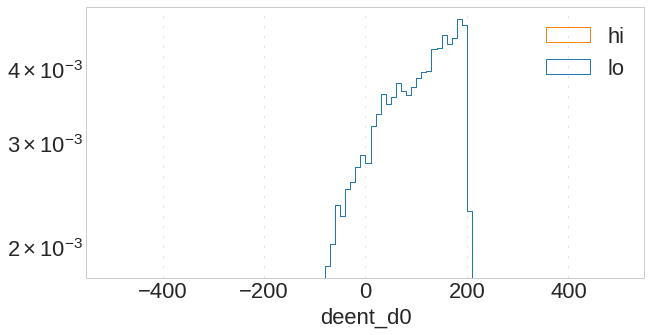

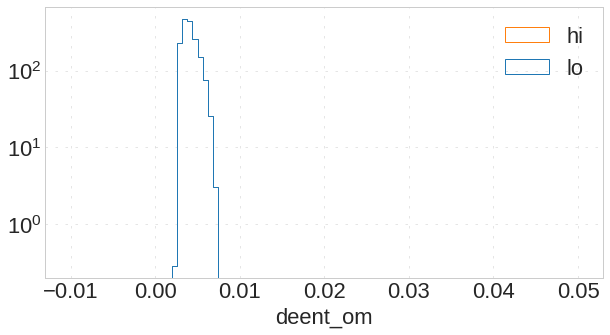

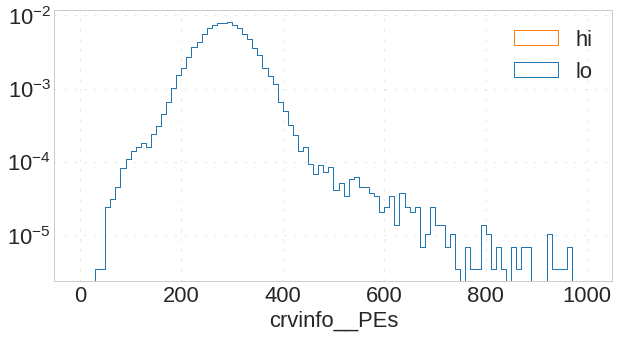

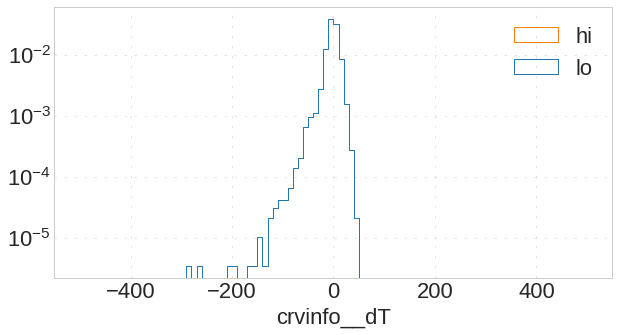

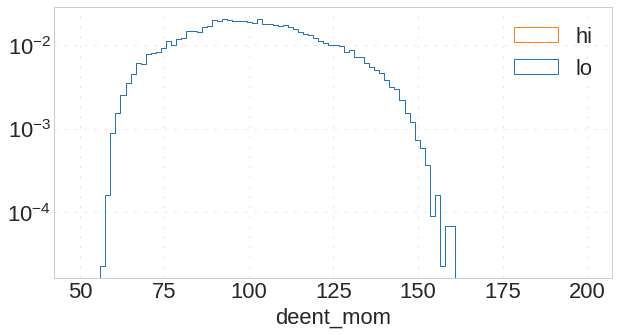

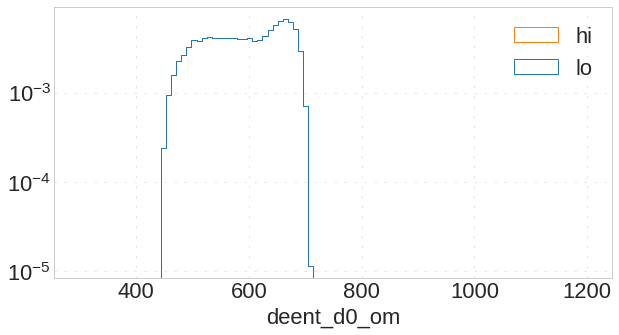

<Figure size 720x360 with 0 Axes>

In [ ]:
variables_list = {'crvinfo__x': [-8000, 1000], 
                  'crvinfo__y': [0, 3500],
                  'crvinfo__z': [-5000, 20000],

                  '_x': [-8000, 1000], 
                  '_y': [0, 3500],
                  '_z': [-5000, 20000],
                  '_crvSectorNumber': [0, 30],
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'crvinfo__PEs': [0, 1000],
                  'crvinfo__dT': [-500, 500],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200]
                  }

for var in variables_list:
  plt.hist([df.query('is_high == 0')[var], df.query('is_high == 1')[var]], bins=100, histtype='step', range=variables_list[var], label=['lo', 'hi'], density=True);
  plt.xlabel(var)
  plt.yscale('log')
  plt.legend()
  plt.figure()

In [ ]:
sectorNames = ["R1","R2","R3","R4","R5","L1","L2","T1","T2","T3","T4","E1","E2","U","D1","D2","D3","D4","C1","C2","C3","C4"]
sectorType = ["R","L","T","E","U","D","C1","C2","C3"]

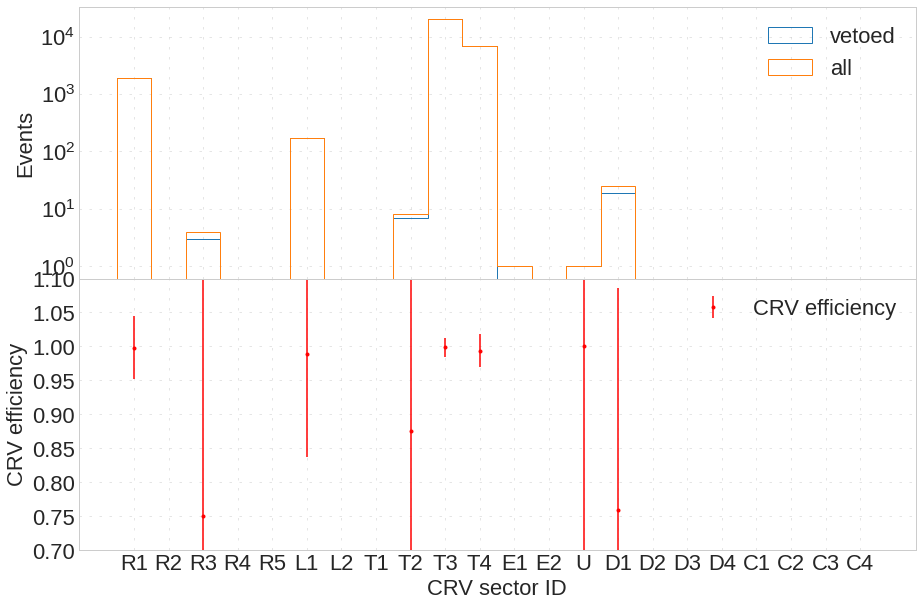

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,10), sharex=True)
fig.subplots_adjust(hspace=0)
                    
#plt.figure()
ax1.plot()
val_of_bins_x1, edges_of_bins_x1, patches_x1 = ax1.hist(df.query('is_high == 0' +  " & not" + crv_time)['_crvSectorNumber'], bins=22, histtype='step', range=[0,22], label=['vetoed']);
val_of_bins_x2, edges_of_bins_x2, patches_x2 = ax1.hist(df.query('is_high == 0')['_crvSectorNumber'], bins=22, histtype='step', range=[0,22], label=['all']);

ratio = np.divide(val_of_bins_x1, val_of_bins_x2, where=(val_of_bins_x2 != 0))
error = np.divide(val_of_bins_x1 * np.sqrt(val_of_bins_x2) + val_of_bins_x2 * np.sqrt(val_of_bins_x1), np.power(val_of_bins_x2, 2), where=(val_of_bins_x2 != 0))

#ax2 = ax1.twinx()
ax1.set_ylabel('Events')
ax2.set_ylabel('CRV efficiency')
ax2.set_xlabel('CRV sector ID')
ax1.set_yscale('log')
#ax2.set_yscale('log')
ax2.set_ylim(0.7, 1.1)
ax2.yaxis.set_ticks(np.arange(0.7, 1.1, 0.05))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

bincenter = 0.5 * (edges_of_bins_x1[1:] + edges_of_bins_x1[:-1])
ax2.errorbar(bincenter, ratio, yerr=error, fmt='.', color='r', label='CRV efficiency')
ax2.xaxis.set_ticks(np.arange(0.5, 22.5, 1))
ax2.set_xticklabels(sectorNames);

ax1.legend()
ax2.legend()
